**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

# NOTE

**If you have not looked at the [regular example notebooks](../2D), please do so first.**  
The notebooks in this folder provide further details about the inner workings of StarDist and might be useful if you want to apply it in a slightly different context.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
In general, training data (for input `X` with associated labels `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.

In [2]:
X = sorted(glob('data/dsb2018/train/images/*.tif'))
Y = sorted(glob('data/dsb2018/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes.

In [4]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 447/447 [00:03<00:00, 111.88it/s]


Split into train and validation datasets.

In [5]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 447
- training:       380
- validation:      67


Training data consists of pairs of input image and label instances.

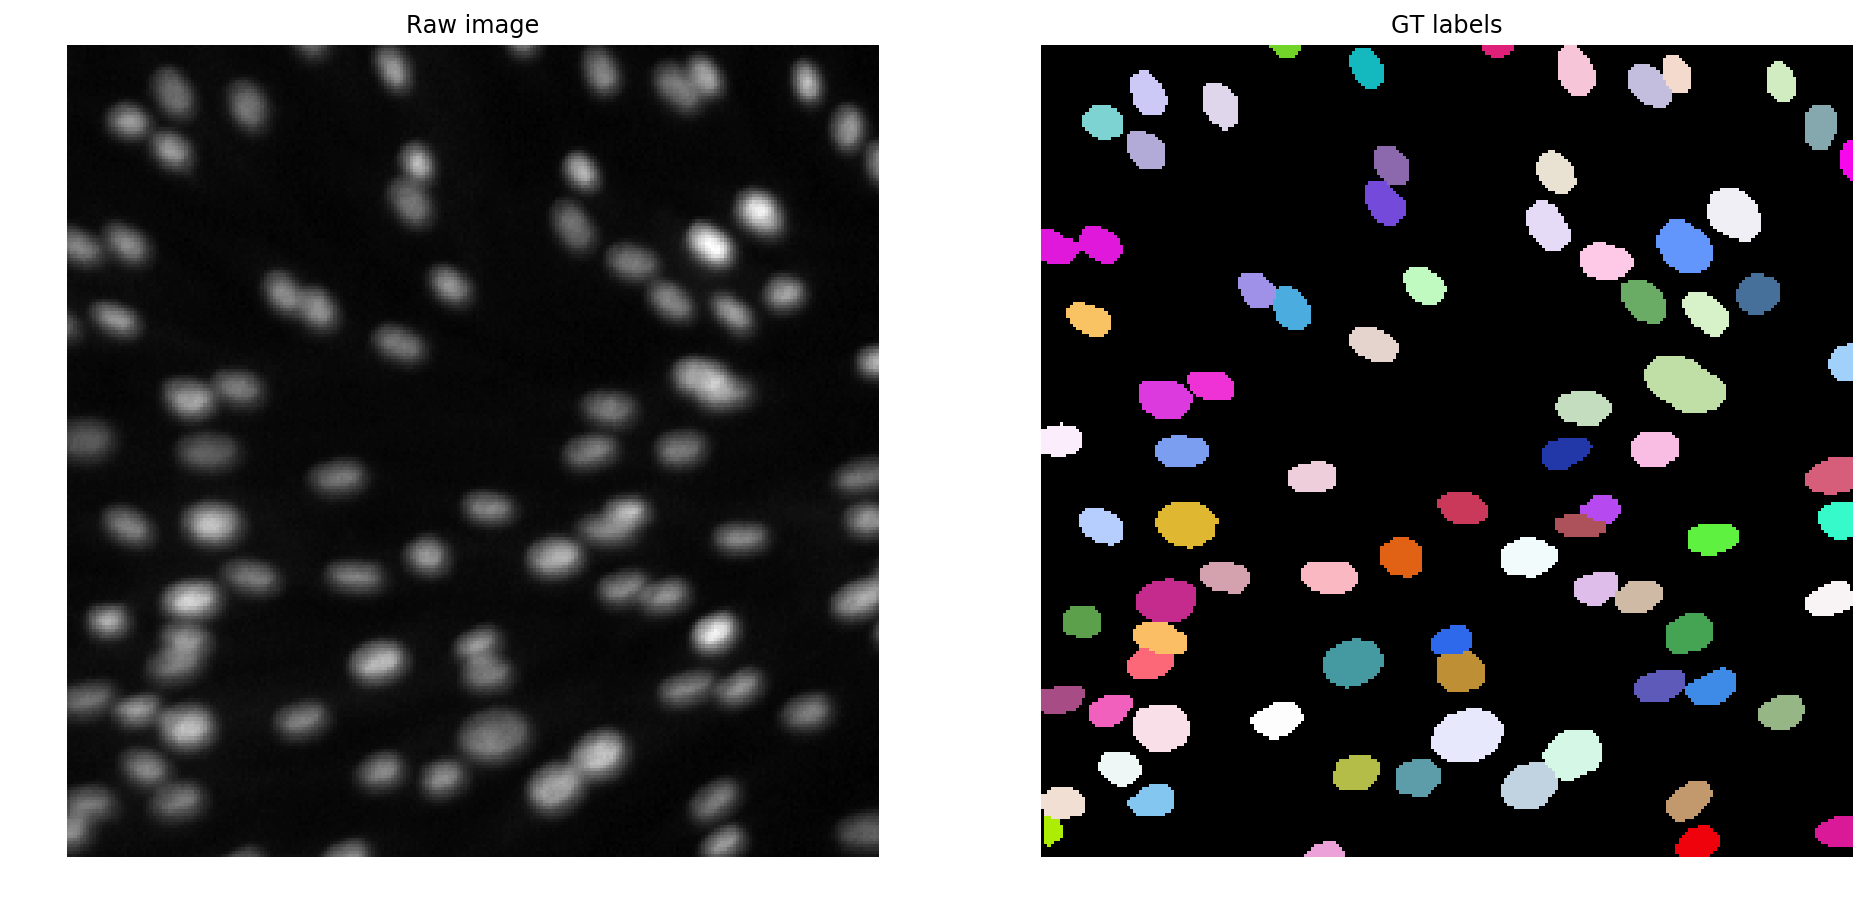

In [6]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

# Data for training StarDist

From the label instance image, all necessary data for training `StarDist2D` can be computed via `StarDistData2D`.  
Note that this here is only for illustration, since it happens automatically when calling `StarDist2D.train` (see below).

## Without shape completion

With `shape_completion = False` (see `Config2D` below), the trained `StarDist2D` model will *not* predict completed shapes for partially visible cells at the image boundary. This is the default behavior.

In [7]:
np.random.seed(42)
data = StarDistData2D(X,Y,batch_size=1,n_rays=32,patch_size=(256,256),shape_completion=False,length=1)

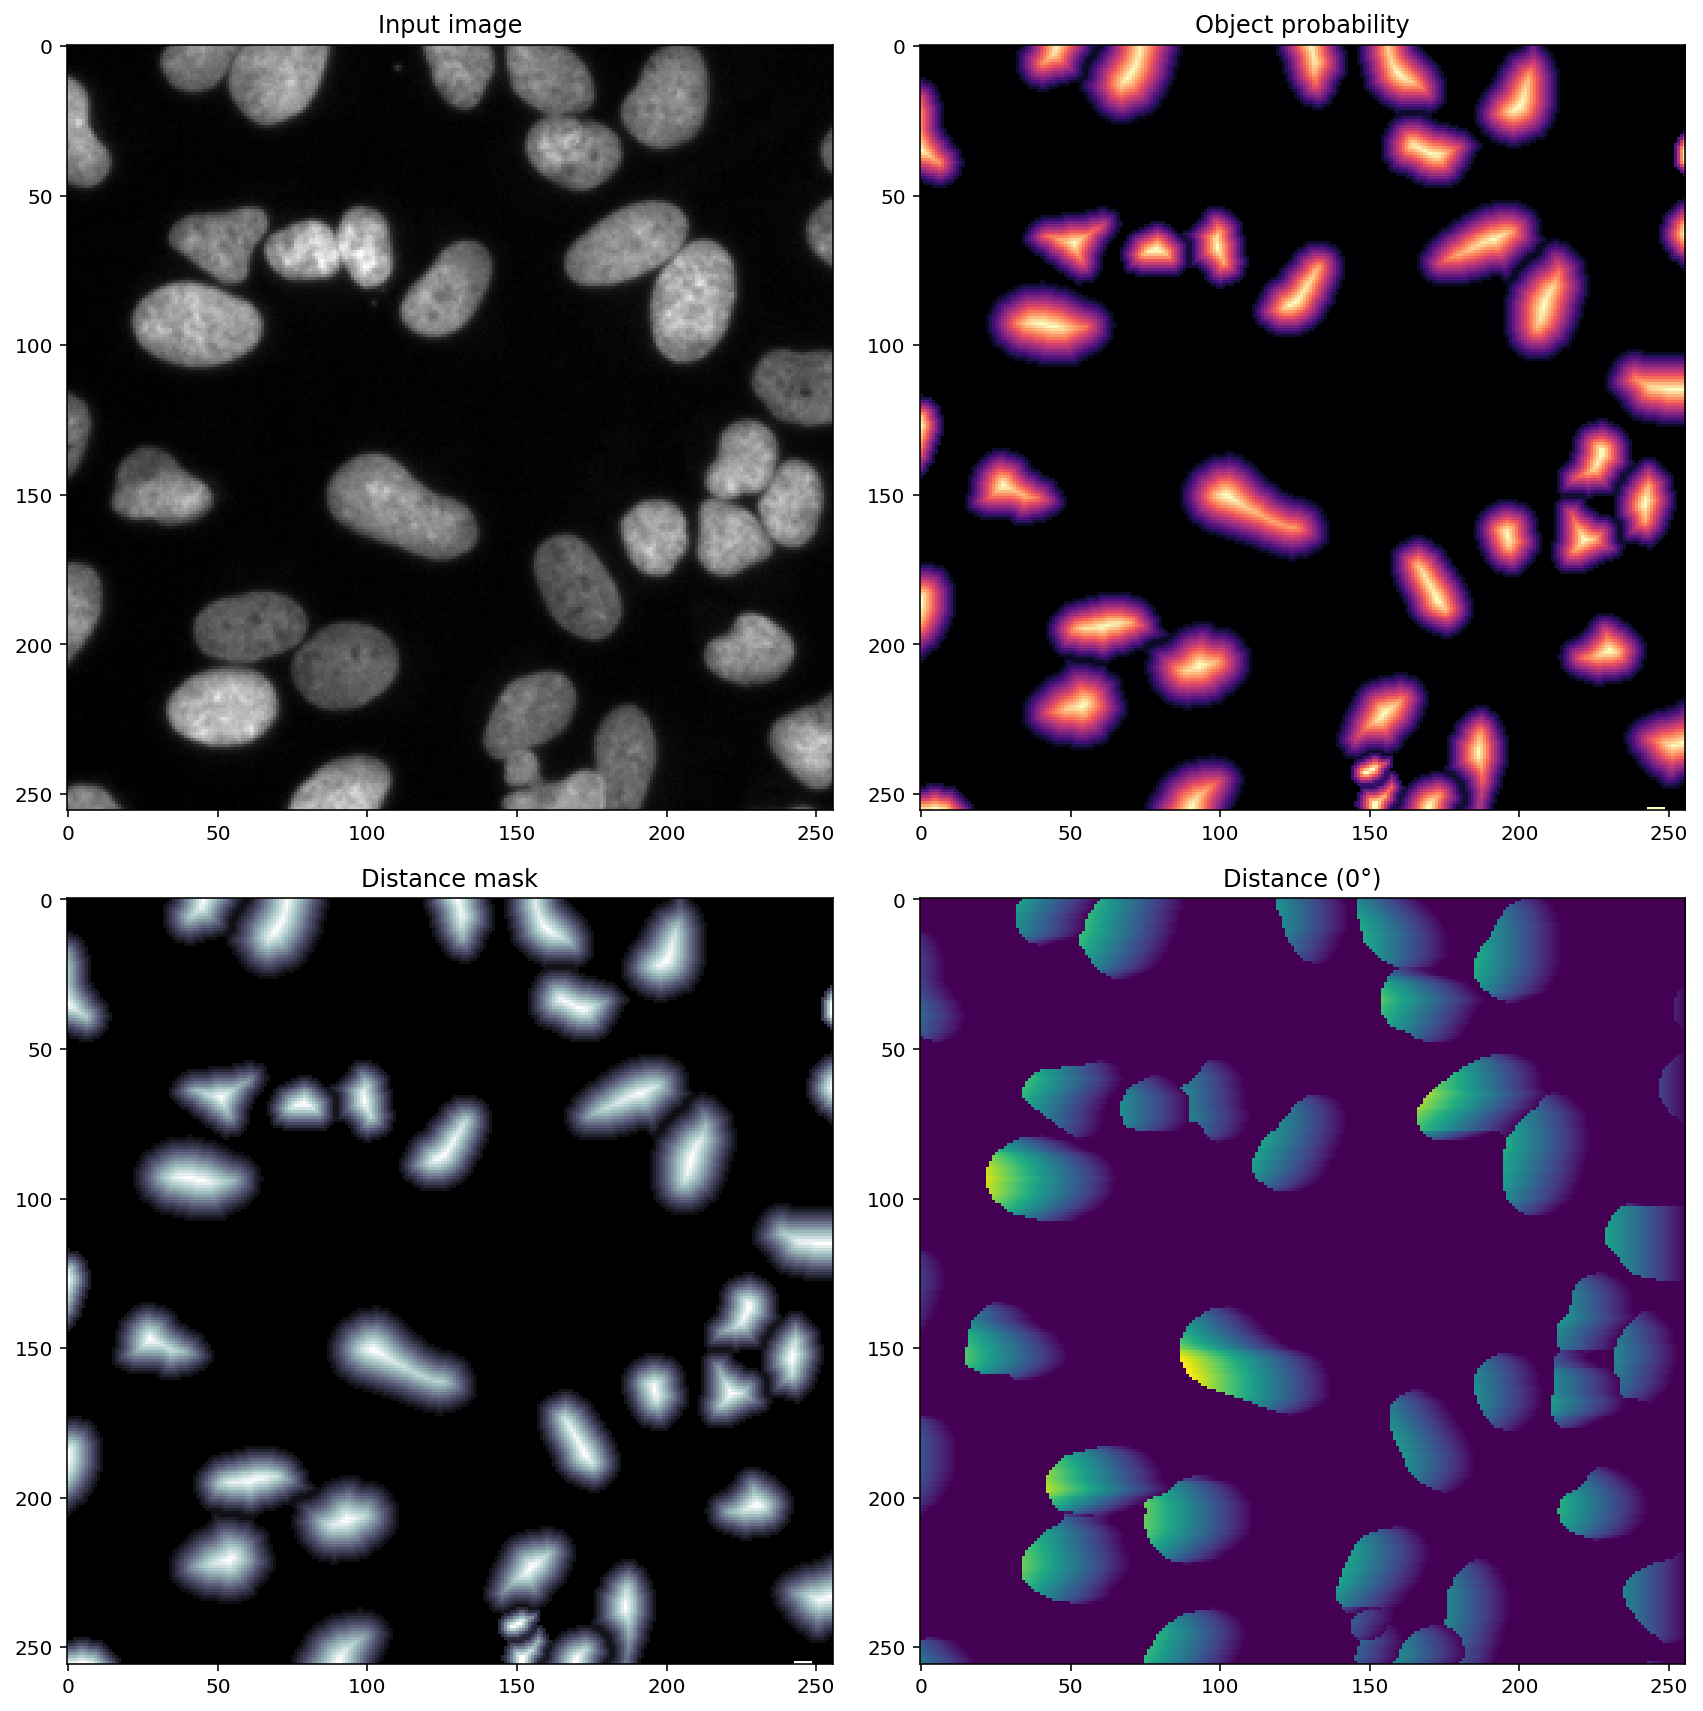

In [8]:
(img,), (prob,dist) = data[0]
dist, dist_mask = dist[...,:-1], dist[...,-1:]

fig, ax = plt.subplots(2,2, figsize=(12,12))
for a,d,cm,s in zip(ax.flat, [img,prob,dist_mask,dist], ['gray','magma','bone','viridis'],
                    ['Input image','Object probability','Distance mask','Distance (0°)']):
    a.imshow(d[0,...,0],cmap=cm)
    a.set_title(s)
plt.tight_layout()
None;

## With shape completion

With `shape_completion = True` (see `Config2D` below), the trained `StarDist2D` model will predict completed shapes for partially visible cells at the image boundary. For this to work, the image needs to be cropped, which is controlled by the `Config2D` parameter `train_completion_crop` (default 32), which should be chosen based on the size of the objects. Furthermore, it may be a good idea to increase `train_batch_size` to offset the reduced amount of pixels per training patch due to cropping.

In [9]:
np.random.seed(42)
data = StarDistData2D(X,Y,batch_size=1,n_rays=32,patch_size=(256,256),shape_completion=True,length=1)

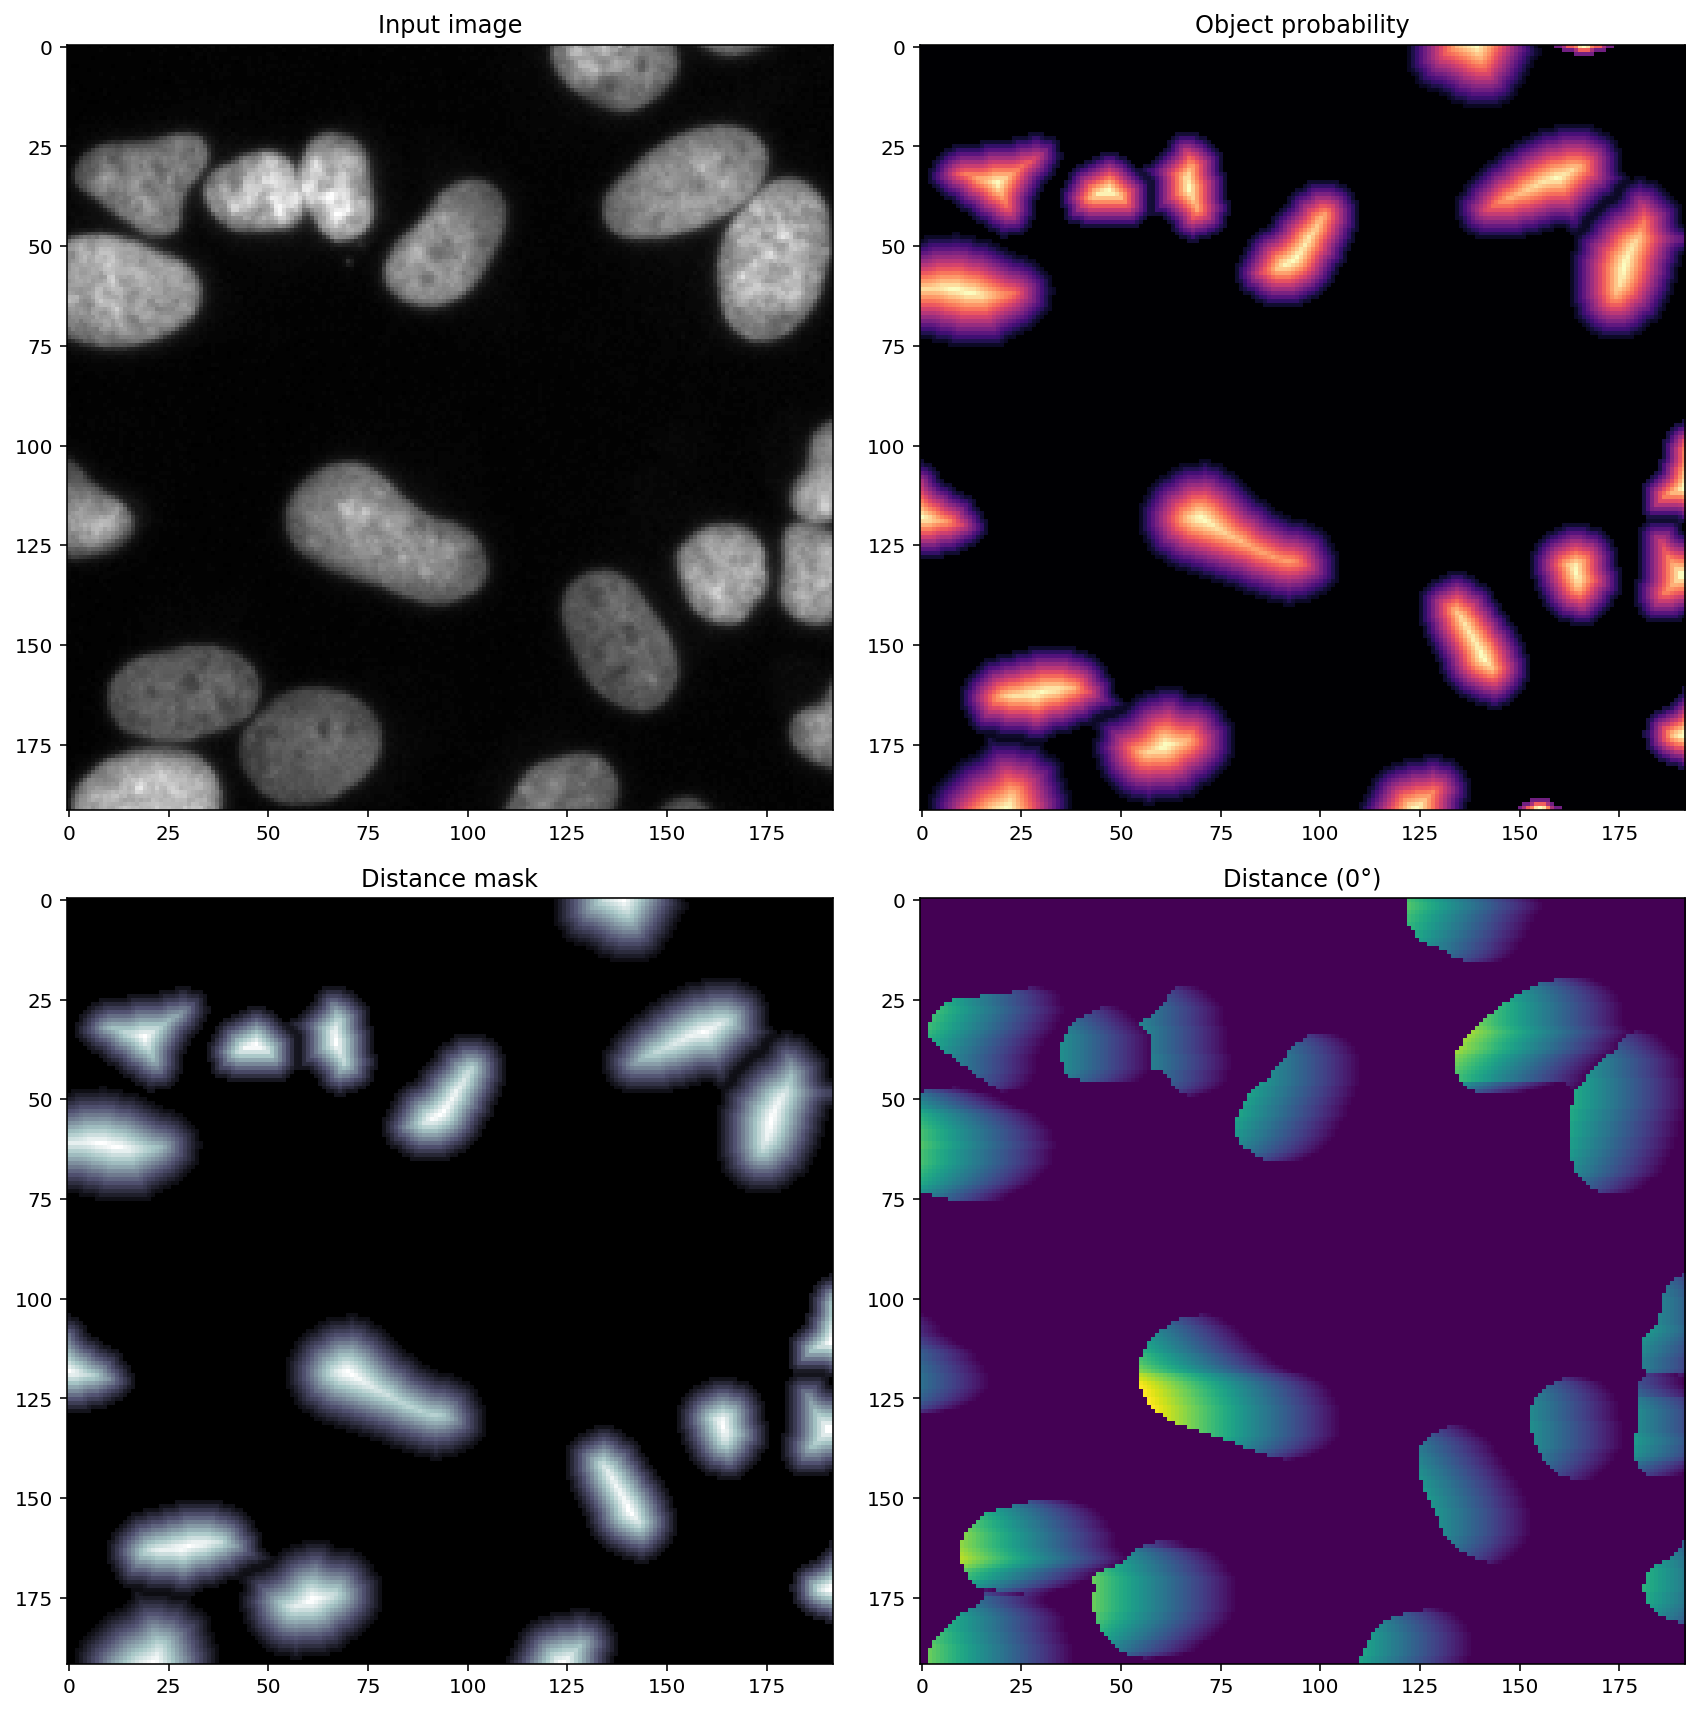

In [10]:
(img,), (prob,dist) = data[0]
dist, dist_mask = dist[...,:-1], dist[...,-1:]

fig, ax = plt.subplots(2,2, figsize=(12,12))
for a,d,cm,s in zip(ax.flat, [img,prob,dist_mask,dist], ['gray','magma','bone','viridis'],
                    ['Input image','Object probability','Distance mask','Distance (0°)']):
    a.imshow(d[0,...,0],cmap=cm)
    a.set_title(s)
plt.tight_layout()
None;

# Training

A `StarDist2D` model is specified via a `Config2D` object.

In [11]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convolution layers.
    unet_n_filter_base : int
        Number of convo

You can monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) by starting it from the current working directory:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


## Without shape completion

In [12]:
conf = Config2D(n_channel_in=n_channel, train_batch_size=4, train_shape_completion=False)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(1, 1), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (1, 1),
 'backbone': 'unet',
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'train_batch_size': 4,
 'train_n_val_patches': None,
 'train_tensorboard': True,

In [13]:
model = StarDist2D(conf, name='stardist_no_shape_completion', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [14]:
%%capture train_log
model.train(X_trn,Y_trn,validation_data=(X_val,Y_val))

In [15]:
# show train log
# train_log()

## With shape completion

In [16]:
conf = Config2D(n_channel_in=n_channel, train_batch_size=7, train_shape_completion=True)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(1, 1), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=7, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=True, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (1, 1),
 'backbone': 'unet',
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': True,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'train_batch_size': 7,
 'train_n_val_patches': None,
 'train_tensorboard': True,


In [17]:
model = StarDist2D(conf, name='stardist_shape_completion', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [18]:
%%capture train_log
model.train(X_trn,Y_trn,validation_data=(X_val,Y_val))

In [19]:
# show train log
# train_log()